In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

In [3]:
from skimage.draw import ellipse

In [4]:
volume1 = np.zeros((100,100,100))

In [26]:
ys, xs = ellipse(70,70, 5, 20)
volume1[ys, xs, 50] = 1.*1e2

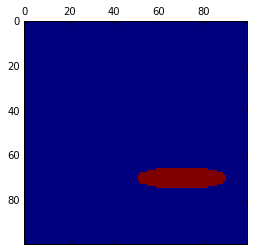

In [27]:
plt.matshow(volume1[...,50]);

In [28]:
gy, gx, gz = np.gradient(volume1)

In [29]:
dSdxyz = np.array([gx, gy, gz])

In [30]:
def transform_points(T, pts=None, c=None, pts_centered=None, c_prime=0):
    '''
    T: 1x12 vector
    c: center of volume 1
    c_prime: center of volume 2
    pts: nx3
    '''
    
    if pts_centered is None:
        pts_centered = pts - c
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    A = Tm[:, :3]
        
    pts_prime = np.dot(A, pts_centered.T) + (t + c_prime)[:,None]
        
    return pts_prime.T

def matrix_exp(w):
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    
    theta = np.sqrt(np.sum(w**2))
    
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/theta**2*np.dot(w_skew, w_skew)
    return exp_w

def matrix_exp_v(v):
    t = v[:3]
    w = v[3:]
    
    theta = np.sqrt(np.sum(w**2))
#     if theta == 0:
#         theta = 1e-10
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/(theta**2)*np.dot(w_skew, w_skew)
    
    V = np.eye(3) + (1-np.cos(theta))/(theta**2)*w_skew + (theta-np.sin(theta))/(theta**3)*np.dot(w_skew, w_skew)
    
    return exp_w, np.dot(V, t)

In [31]:
R = matrix_exp( np.array([0,0,np.deg2rad(-30)]))

In [32]:
R

array([[ 0.8660254,  0.5      ,  0.       ],
       [-0.5      ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  1.       ]])

In [33]:
nz_ys, nz_xs, nz_zs = np.where(volume1)

In [34]:
test_ydim, test_xdim, test_zdim = volume1.shape

In [35]:
nzs = np.c_[nz_xs, nz_ys, nz_zs]

In [36]:
centroid = nzs.mean(axis=0)

In [37]:
nzs2_centered = np.dot(R, (nzs - centroid).T).T

In [38]:
volume2 = np.zeros_like(volume1[...,0])

In [39]:
for x,y,z in nzs2_centered + centroid:
    volume2[y,x] = 1

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


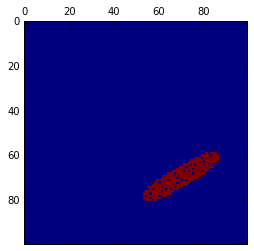

In [40]:
plt.figure(figsize=(10,10));
plt.matshow(volume2);

In [41]:
def step(T):
    '''
    T: 1x12 vector
    l: landmark class label
    '''
    
    pts_prime = transform_points(T, pts_centered=nzs2_centered, c_prime=centroid)
#     print pts_prime
    
    xs_prime = pts_prime[:,0]
    ys_prime = pts_prime[:,1]
    zs_prime = pts_prime[:,2]
    
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
    
    print 'nz', np.count_nonzero(valid) 
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform'
    
    xs_prime_valid = xs_prime[valid].astype(np.int16)
    ys_prime_valid = ys_prime[valid].astype(np.int16)
    zs_prime_valid = zs_prime[valid].astype(np.int16)
    
    voxel_probs_valid = volume1[ys_prime_valid, xs_prime_valid, zs_prime_valid]
    score = voxel_probs_valid.sum()

    dSdx = gx[ys_prime_valid, xs_prime_valid, zs_prime_valid]
    dSdy = gy[ys_prime_valid, xs_prime_valid, zs_prime_valid]
    dSdz = gz[ys_prime_valid, xs_prime_valid, zs_prime_valid]

    xss = xs_prime[valid].astype(np.float)
    yss = ys_prime[valid].astype(np.float)
    zss = zs_prime[valid].astype(np.float)
    
    dMdv = np.c_[dSdx, dSdy, dSdz, 
                 -dSdy*zss + dSdz*yss, 
                 dSdx*zss - dSdz*xss,
                 -dSdx*yss + dSdy*xss].sum(axis=0)
    
#     dMdv = np.c_[dSdx, dSdy, dSdz, 
#                  dSdy*zs_prime_valid - dSdz*ys_prime_valid, 
#                  -dSdx*zs_prime_valid + dSdz*xs_prime_valid,
#                  dSdx*ys_prime_valid - dSdy*xs_prime_valid].sum(axis=0)
    
#     dMdv[3:] = 0
    
    print 'dMdv:', dMdv
    print '## score:', score
    
#     lr1, lr2 = (1e-2, 1e-8)
#     lr1, lr2 = (0, 1e-5)
#     lr1, lr2 = (0, 1e-5)
    
    global dMdv_historical
    dMdv_historical += dMdv**2
    dMdv_adjusted = dMdv / (1e-10 + np.sqrt(dMdv_historical))
    print np.sqrt(dMdv_historical)
    
#     if iteration < 0:
#         lr = np.array([0, 0, 0, 0, 0, 1e-5])
#         v_opt = lr * dMdv # no minus sign because maximizing    
#     else:
    lr = np.array([0,0,0,0,0,1e-2])
    v_opt = lr * dMdv_adjusted # no minus sign because maximizing

#     global iteration
#     v_opt = lr * np.exp(-iteration/100.) * dMdv # no minus sign because maximizing
#     v_opt = lr * dMdv # no minus sign because maximizing
    print 'v_opt:', v_opt
    
    theta = np.sqrt(np.sum(v_opt[3:]**2))
    print 'theta:', theta, np.rad2deg(theta)
#     if theta > 2*np.pi:
#         theta2 = theta % (2*np.pi)
#         v_opt[3:] = v_opt[3:]/theta*theta2
#         print 'theta2:', theta2, np.rad2deg(theta2)
    
    exp_w, Vt = matrix_exp_v(v_opt)
    print 'Vt:' , Vt
    print 'exp_w:', exp_w
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    R = Tm[:, :3]
                        
    R_new = np.dot(exp_w, R)
    t_new = np.dot(exp_w, t) + Vt

#     exp_w_new = np.dot(R, exp_w)
#     t_new = np.dot(R, Vt) + t
    
#     print 'exp_w_new:', exp_w_new
#     print 't_new:', t_new
    print '\n'

    return np.column_stack([R_new, t_new]).flatten(), score

In [42]:
T = [1,0,0,0,0,1,0,0,0,0,1,0]

# R = matrix_exp( np.array([0,0,np.deg2rad(15)]))
# T = np.column_stack([R, (0,0,0)]).flatten()

dMdv_historical = np.zeros((6,))

score_best = 0
scores = []

for iteration in range(1000):
    Tnew, s = step(T)
    
    print Tnew
    
    scores.append(s)
    
    if s > score_best:
        best_gradient_descent_params = T
        score_best = s
        
    T = Tnew

nz 299
dMdv: [     0.              0.              0.              0.              0.
  16770.86015345]
## score: 14900.0
[     0.              0.              0.              0.              0.
  16770.86015345]
v_opt: [ 0.    0.    0.    0.    0.    0.01]
theta: 0.01 0.572957795131
Vt: [ 0.  0.  0.]
exp_w: [[ 0.99995    -0.00999983  0.        ]
 [ 0.00999983  0.99995     0.        ]
 [ 0.          0.          1.        ]]


[ 0.99995    -0.00999983  0.          0.          0.00999983  0.99995     0.
  0.          0.          0.          1.          0.        ]
nz 299
dMdv: [     0.              0.              0.              0.              0.
  17094.73569395]
## score: 15000.0
[     0.              0.              0.              0.              0.
  23947.68754458]
v_opt: [ 0.          0.          0.          0.          0.          0.00713837]
theta: 0.00713836593288 0.408998240574
Vt: [ 0.  0.  0.]
exp_w: [[ 0.99997452 -0.00713831  0.        ]
 [ 0.00713831  0.99997452  0.     

In [43]:
print scores[0]
print score_best
print scores[-1]
print best_gradient_descent_params.reshape((3,4))

R = matrix_exp( np.array([0,0,np.deg2rad(30)]))
print np.column_stack([R, (0,0,0)])

14900.0
27900.0
24900.0
[[ 0.8907603  -0.45447341  0.          0.        ]
 [ 0.45447341  0.8907603   0.          0.        ]
 [ 0.          0.          1.          0.        ]]
[[ 0.8660254 -0.5        0.         0.       ]
 [ 0.5        0.8660254  0.         0.       ]
 [ 0.         0.         1.         0.       ]]


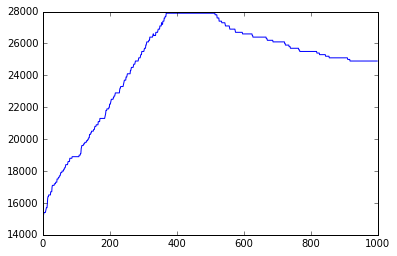

In [44]:
plt.plot(scores);